Cross Validation Result (5-Fold)
Fold Accuracy:  [0.58385876 0.56242119 0.58385876 0.73232323 0.76515152]
Average Accuracy:  0.6455226922440038
Data Training Result
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       925
           1       0.90      0.87      0.88       933
           2       0.90      0.94      0.92       916

    accuracy                           0.91      2774
   macro avg       0.91      0.91      0.91      2774
weighted avg       0.91      0.91      0.91      2774

Data Validation Result
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       396
           1       0.50      0.45      0.47       388
           2       0.62      0.77      0.69       405

    accuracy                           0.62      1189
   macro avg       0.62      0.61      0.61      1189
weighted avg       0.62      0.62      0.61      1189



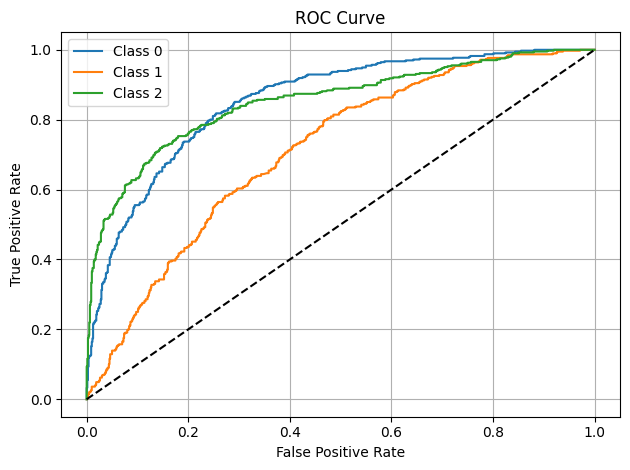

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Preprocessing
df = pd.read_excel("clean_data.xlsx")
df = df.rename(columns={"text ": "text"})
df.dropna(subset=["text", "label"], inplace=True)

x_text = df["text"]
y_label = df["label"]

# Balancing (with SMOTE)
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
x = tfidf.fit_transform(x_text)
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y_label)

# Split Data (training, testing, and validation with 70:30)
x_train, x_test, y_train_label, y_test_label = train_test_split(x_resampled, y_resampled, test_size=0.3, random_state=42)

# Tuning
param_grid = {'alpha': [0.1, 0.5, 1.0]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid.fit(x_train, y_train_label)
model = grid.best_estimator_

# Cross Validation (with 5-fold)
cv_scores = cross_val_score(model, x_resampled, y_resampled, cv=5, scoring='accuracy')
print("Cross Validation Result (5-Fold)")
print("Fold Accuracy: ", cv_scores)
print("Average Accuracy: ", cv_scores.mean())

# Evaluation
y_train_pred = model.predict(x_train)
print("Data Training Result")
print(classification_report(y_train_label, y_train_pred))

y_test_pred = model.predict(x_test)
print("Data Validation Result")
print(classification_report(y_test_label, y_test_pred))

# ROC Curve
classes = sorted(y_label.unique())
y_test_bin = label_binarize(y_test_label, classes=classes)
y_score = model.predict_proba(x_test)

fpr = dict()
tpr = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()